
INFLATION FORECASTING

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
inf = pd.read_excel("monthly inflation.xlsx",index_col="date")

In [ ]:
# defining high inflation: +1 std
mu, sigma = inf["inflation"].mean(), inf["inflation"].std()
inf["high_inf"] = [1 if pi > (mu + sigma) else 0 for pi in inf["inflation"]]

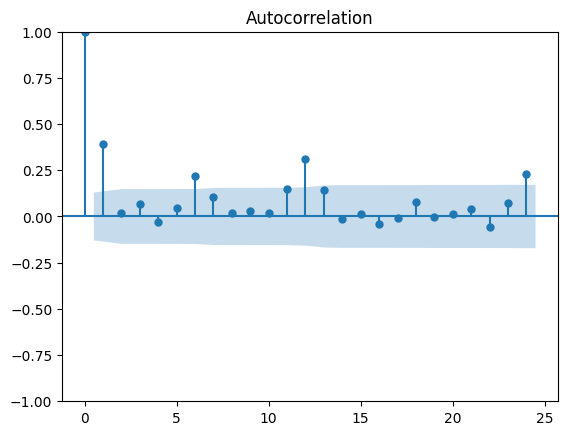

In [ ]:
plot_acf(inf["inflation"])
plt.show()

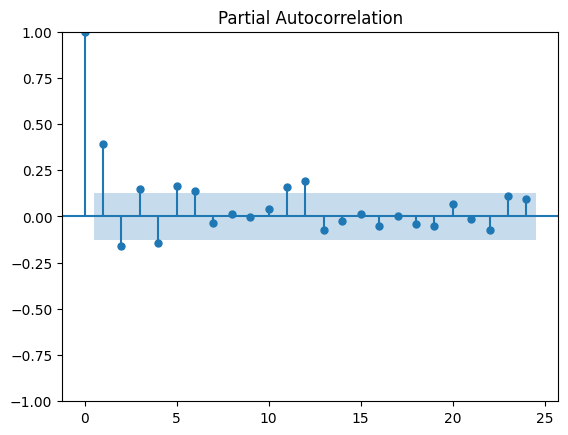

In [ ]:
plot_pacf(inf["inflation"])
plt.show()

We might want to consider 1, 6 and 12 lagged values of inflation.

In [ ]:
inf["high_inf_lag1"] = inf["high_inf"].shift(1)
inf["high_inf_lag6"] = inf["high_inf"].shift(6)
inf["high_inf_lag12"] = inf["high_inf"].shift(12)
inf = inf.dropna().drop(["inflation"], axis=1)

In [ ]:
dat = pd.read_excel("data1.xlsx",index_col=0)
dat.head(10)

,FFPI,usdtry,brent/try,M2,muvx,curr_acc,mv_raw_mat,mv_cons_goods,PPI_food_prod,bist100,us2yr,us10yr,int_rate_3mo,int_rate_1yr_longer
date,,,,,,,,,,,,,,
2000-12-01,54.449967,0.682003,17.374509,31912095.0,54.99,-745,-3.7,-15.7,1.27,94.06,5.352000,5.24,81.83,104.45
2001-01-01,53.809421,0.674868,17.404859,32202029.0,51.63,-724,-1.8,-13.2,1.05,104.38,4.760000,5.16,69.36,36.63
2001-02-01,54.248992,0.742781,20.721003,35311355.0,46.96,-85,-11.7,-7.0,1.44,85.12,4.656842,5.10,69.34,32.92
2001-03-01,55.077353,0.972084,24.335691,38487237.0,43.30,238,-9.1,-14.8,7.84,75.49,4.342273,4.89,110.50,50.40
2001-04-01,54.619706,1.214595,31.601442,38941957.0,37.51,680,-13.4,-9.2,12.50,125.91,4.234000,5.14,110.79,53.14
2001-05-01,55.409242,1.136937,32.332522,39096847.0,36.45,428,10.5,5.5,7.15,101.39,4.260000,5.39,87.56,50.64
2001-06-01,54.770390,1.220357,34.174649,40377691.0,41.38,314,-1.1,5.2,2.86,112.76,4.080000,5.28,77.23,51.33
2001-07-01,56.499642,1.325668,33.130257,38282033.0,37.94,463,1.3,-5.6,4.30,98.82,4.038571,5.24,73.50,44.05
2001-08-01,56.579570,1.406423,36.195832,40805064.0,40.37,866,14.8,-7.9,3.23,97.72,3.757391,4.97,69.40,42.66


## Stationarity Check

In [ ]:
def check_stationarity(series):
  result = adfuller(series.values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  status = "Stationary" if (result[1] <= 0.05) & (result[4]['5%'] > result[0]) else "Non-stationary"
  print(status)
  return status

In [ ]:
stationary_series = []
non_stationary_series = []
for col in dat.columns:
  print(col)
  check_stationarity(dat[col])
  if check_stationarity(dat[col]) == "Stationary":
    stationary_series.append(col)
  else:
    non_stationary_series.append(col)
  print("----------------------")

print(f"Stationary series: {stationary_series}")
print(f"Non-stationary series: {non_stationary_series}")

FFPI
ADF Statistic: -2.010870
p-value: 0.281828
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Non-stationary
ADF Statistic: -2.010870
p-value: 0.281828
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Non-stationary
----------------------
usdtry
ADF Statistic: 4.765076
p-value: 1.000000
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
ADF Statistic: 4.765076
p-value: 1.000000
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
----------------------
brent/try
ADF Statistic: -0.782154
p-value: 0.824308
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
ADF Statistic: -0.782154
p-value: 0.824308
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
----------------------
M2
ADF Statistic: 4.251134
p-value: 1.000000
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
ADF Statistic: 4.251134
p-value: 1.000000
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574
Non-stationary
--------------

In [ ]:
for col in dat[non_stationary_series]:
  print(col)
  check_stationarity(dat[col].pct_change().dropna())
  print("----------------------")

FFPI
ADF Statistic: -8.022084
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary
----------------------
usdtry
ADF Statistic: -8.911136
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary
----------------------
brent/try
ADF Statistic: -7.628882
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Stationary
----------------------
M2
ADF Statistic: -16.155227
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary
----------------------
muvx
ADF Statistic: -18.822515
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary
----------------------
bist100
ADF Statistic: -17.915751
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary
----------------------
us2yr
ADF Statistic: -3.046727
p-value: 0.030755
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Stationary
----------------------
us10yr
ADF Statistic: -10.050991
p-v

In [ ]:
x1 = dat[non_stationary_series].pct_change().dropna()*100
x1.head(10)

,FFPI,usdtry,brent/try,M2,muvx,bist100,us2yr,us10yr
date,,,,,,,,
2001-01-01,-1.176395,-1.046086,0.174677,0.908540,-6.110202,10.971720,-11.061286,-1.526718
2001-02-01,0.816905,10.063138,19.052979,9.655683,-9.045129,-18.451811,-2.167183,-1.162791
2001-03-01,1.526960,30.870849,17.444562,8.993940,-7.793867,-11.313440,-6.754993,-4.117647
2001-04-01,-0.830916,24.947460,29.856358,1.181483,-13.371824,66.790303,-2.493458,5.112474
2001-05-01,1.445515,-6.393685,2.313440,0.397746,-2.825913,-19.474228,0.614077,4.863813
2001-06-01,-1.152971,7.337234,5.697442,3.276080,13.525377,11.214124,-4.225352,-2.040816
2001-07-01,3.157276,8.629530,-3.056044,-5.190138,-8.313195,-12.362540,-1.015406,-0.757576
2001-08-01,0.141466,6.091648,9.253097,6.590640,6.404850,-1.113135,-6.962366,-5.152672
2001-09-01,-2.121253,4.918937,5.330332,3.204578,5.845925,-22.779370,-16.994977,-4.828974


In [ ]:
df = pd.concat([inf, dat[stationary_series], x1], axis=1).dropna()
y = df["high_inf"]
X = df.drop(columns=["high_inf"])

## Cross Validation methods

### Time Series cross validation with and without gap

In [ ]:
tscv = TimeSeriesSplit(test_size=1,n_splits=int(np.floor(len(X)*.8)))
tscv_gap6 = TimeSeriesSplit(test_size=1,gap=6,n_splits=int(np.floor(len(X)*.8)))
tscv_gap12 = TimeSeriesSplit(test_size=1,gap=12,n_splits=int(np.floor(len(X)*.8)))

### Sliding window with and without gap

In [ ]:
def my_cv(X, window, gap=0):
  """
  nothing fancy, just sliding window cross validation
  """
  step = 1  # one step ahead
  train_list = []
  test_list = []
  for i in range(0,len(X)-window-gap):
    train_list=(list(range(0+i,window+i)))
    test_list=(list(range(window+i+gap,window+i+step+gap)))
    yield (np.array(train_list), np.array(test_list))

In [ ]:
rolling = list(my_cv(X,60))
rolling_gap6 = list(my_cv(X,60,6))
rolling_gap12 = list(my_cv(X,60,12))

### hv-blocked cross validation

In [ ]:
def my_hvb(X, gap, embargo=0):
  """
  hv-blocked cross validation
  choose gap wisely to eliminate dependency
  """
  train_list = []
  test_list = []
  for i in range(0,len(X)):
    train_list=(list(range(0,i-gap))+list(range(i+1+gap+embargo, len(X))))
    test_list=[i]
    yield (np.array(train_list), np.array(test_list))

In [ ]:
hvb = list(my_hvb(X,12))
# hvb_emb = list(my_hvb(X,12,1))

In [ ]:
cv_dict = {
    "TS CV": list(tscv.split(X)),
    "TS CV w/ 6 period gap": list(tscv_gap6.split(X)),
    "TS CV w/ 12 period gap": list(tscv_gap12.split(X)),
    "Sliding window": rolling,
    "Sliding window w/ 6 period gap": rolling_gap6,
    "Sliding window w/ 12 period gap": rolling_gap12,
    "hv-blocked": hvb
}

## Logistic Regression + Regularization

In [ ]:
logreg_betas = pd.DataFrame(columns=X.columns, index=cv_dict.keys())
l1_betas = pd.DataFrame(columns=X.columns, index=cv_dict.keys())
l2_betas = pd.DataFrame(columns=X.columns, index=cv_dict.keys())
elnet_betas = pd.DataFrame(columns=X.columns, index=cv_dict.keys())

logreg_results = pd.DataFrame(index=cv_dict.keys())
l1_results = pd.DataFrame(index=cv_dict.keys())
l2_results = pd.DataFrame(index=cv_dict.keys())
elnet_results = pd.DataFrame(index=cv_dict.keys())

### Logistic Regression (without penalty)

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(penalty=None, max_iter=400))])
for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train,y_train)
    yhat = pipe.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  logreg_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  logreg_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  logreg_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  logreg_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  logreg_betas.loc[name] = pipe.named_steps["model"].coef_[0]

logreg_results.round(4).reset_index(names="cv method")

,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8571,0.2308,0.1765,0.5551
1,TS CV w/ 6 period gap,0.8571,0.1818,0.1176,0.5290
2,TS CV w/ 12 period gap,0.8631,0.2000,0.1176,0.5323
3,Sliding window,0.7800,0.2258,0.4375,0.6292
4,Sliding window w/ 6 period gap,0.7500,0.1875,0.3750,0.5859
5,Sliding window w/ 12 period gap,0.7754,0.1667,0.2667,0.5520
6,hv-blocked,0.8714,0.3636,0.1667,0.5645


In [ ]:
logreg_betas.T

,TS CV,TS CV w/ 6 period gap,TS CV w/ 12 period gap,Sliding window,Sliding window w/ 6 period gap,Sliding window w/ 12 period gap,hv-blocked
high_inf_lag1,0.066071,-0.092351,-0.102005,7.165981,916.57208,628.467071,-0.102005
high_inf_lag6,0.111434,0.088306,0.094871,-35.765405,-77392.533465,-1889.76335,0.094871
high_inf_lag12,0.545331,0.485908,0.471595,32.287687,21670.034362,2376.753299,0.471595
curr_acc,0.194288,0.127292,0.040586,-1.792969,496.587998,-1145.152166,0.040586
mv_raw_mat,0.120418,0.016565,-0.038624,-9.772398,-19920.251322,-373.751039,-0.038624
mv_cons_goods,-0.610706,-0.728172,-0.819361,-9.114818,-56.825503,-172.736088,-0.819361
PPI_food_prod,0.338887,0.019857,0.051175,6.571984,5986.297812,-1074.35348,0.051175
int_rate_3mo,0.463975,0.446228,0.043194,37.226543,19004.993443,4526.870971,0.043194
int_rate_1yr_longer,0.026145,0.287124,0.722173,-30.310392,-21029.707113,-2991.16536,0.722173
FFPI,0.30645,0.254505,0.217884,1.538216,8393.501777,358.394028,0.217884


### Logistic Regression + L1

In [ ]:
params = {"model__C": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
pipe = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(solver="liblinear", penalty="l1"))])

In [ ]:
for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(pipe, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X,y)
  mdl = grid_search.best_estimator_[1]
  pipe = Pipeline([("scaler", StandardScaler()), ("model", mdl)])
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train,y_train)
    yhat = pipe.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  l1_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  l1_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  l1_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  l1_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  l1_betas.loc[name] = pipe.named_steps["model"].coef_[0]

l1_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 150 folds for each of 8 candidates, totalling 1200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 144 folds for each of 8 candidates, totalling 1152 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 8 candidates, totalling 1104 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 210 folds for each of 8 candidates, totalling 1680 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9048,0.6667,0.1176,0.5555
1,TS CV w/ 6 period gap,0.9048,0.6000,0.1765,0.5816
2,TS CV w/ 12 period gap,0.9048,0.6000,0.1765,0.5816
3,Sliding window,0.8933,0.0000,0.0000,0.5000
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.8913,0.0000,0.0000,0.5000
6,hv-blocked,0.8857,0.0000,0.0000,0.5000


In [ ]:
l1_betas.T

,TS CV,TS CV w/ 6 period gap,TS CV w/ 12 period gap,Sliding window,Sliding window w/ 6 period gap,Sliding window w/ 12 period gap,hv-blocked
high_inf_lag1,0.098225,0.0,0.0,0.0,0.0,0.0,0.0
high_inf_lag6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
high_inf_lag12,0.473189,0.413939,0.41285,0.0,0.0,0.0,0.0
curr_acc,0.152576,0.120074,0.043701,0.0,0.0,0.0,0.0
mv_raw_mat,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mv_cons_goods,-0.388234,-0.480825,-0.570212,0.0,0.0,0.0,0.0
PPI_food_prod,0.336378,0.070947,0.091625,0.0,0.0,0.0,0.0
int_rate_3mo,0.386704,0.470921,0.096632,0.0,0.0,0.0,0.0
int_rate_1yr_longer,0.0,0.094535,0.488994,0.0,0.0,0.0,0.0
FFPI,0.024692,0.0,0.0,0.0,0.0,0.0,0.0


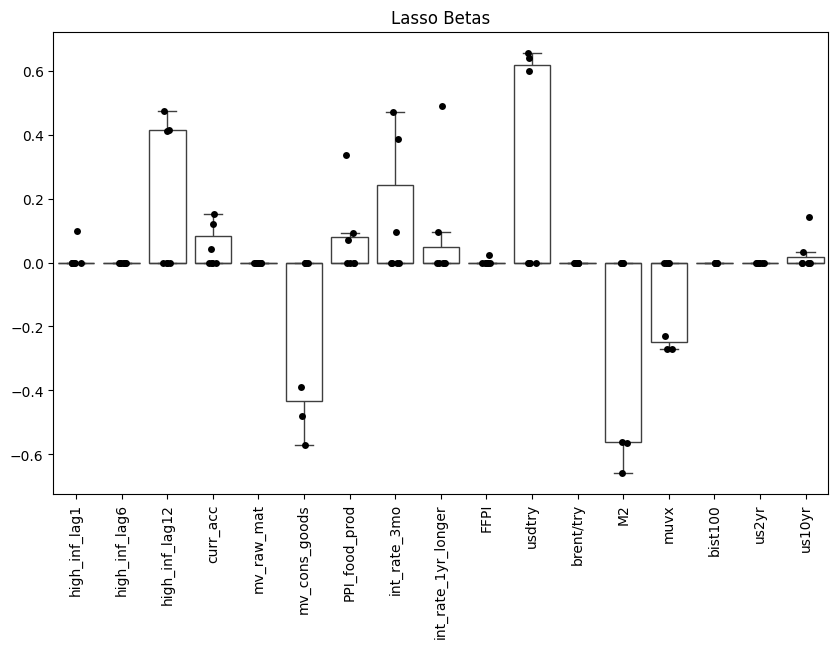

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=l1_betas, color="white", showfliers=False)
sns.stripplot(data=l1_betas, color="black")
plt.title("Lasso Betas")
plt.xticks(rotation=90)
plt.show()

### Logistic Regression + L2

In [ ]:
params = {"model__C": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
pipe = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression())])

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(pipe, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X,y)
  mdl = grid_search.best_estimator_[1]
  pipe = Pipeline([("scaler", StandardScaler()), ("model", mdl)])
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train,y_train)
    yhat = pipe.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  l2_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  l2_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  l2_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  l2_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  l2_betas.loc[name] = pipe.named_steps["model"].coef_[0]

l2_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 168 folds for each of 8 candidates, totalling 1344 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 168 folds for each of 8 candidates, totalling 1344 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 150 folds for each of 8 candidates, totalling 1200 fits
Fitting 144 folds for each of 8 candidates, totalling 1152 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 8 candidates, totalling 1104 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 210 folds for each of 8 candidates, totalling 1680 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9048,0.6667,0.1176,0.5555
1,TS CV w/ 6 period gap,0.8988,0.0000,0.0000,0.5000
2,TS CV w/ 12 period gap,0.8988,0.0000,0.0000,0.5000
3,Sliding window,0.9067,1.0000,0.1250,0.5625
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.8913,0.0000,0.0000,0.5000
6,hv-blocked,0.8857,0.0000,0.0000,0.5000


In [ ]:
l2_betas.T

,TS CV,TS CV w/ 6 period gap,TS CV w/ 12 period gap,Sliding window,Sliding window w/ 6 period gap,Sliding window w/ 12 period gap,hv-blocked
high_inf_lag1,0.140656,0.00089,0.000856,0.226449,0.000433,0.000399,0.000856
high_inf_lag6,0.003886,0.00039,0.000401,-0.159561,-0.000254,-0.000291,0.000401
high_inf_lag12,0.346392,0.001488,0.001444,0.324341,0.000368,0.000332,0.001444
curr_acc,0.185028,0.001371,0.001344,0.18074,0.000633,0.000601,0.001344
mv_raw_mat,-0.06714,-0.001078,-0.001148,-0.09967,-0.000285,-0.000328,-0.001148
mv_cons_goods,-0.244432,-0.001003,-0.00111,-0.088972,-0.000432,-0.000529,-0.00111
PPI_food_prod,0.306563,0.001195,0.001245,0.343715,0.00064,0.000627,0.001245
int_rate_3mo,0.190615,0.001644,0.001587,0.15216,0.000573,0.000482,0.001587
int_rate_1yr_longer,0.134746,0.001545,0.00151,-0.004336,0.000318,0.000297,0.00151
FFPI,-0.001906,-0.000717,-0.000758,0.184511,0.000142,0.000191,-0.000758


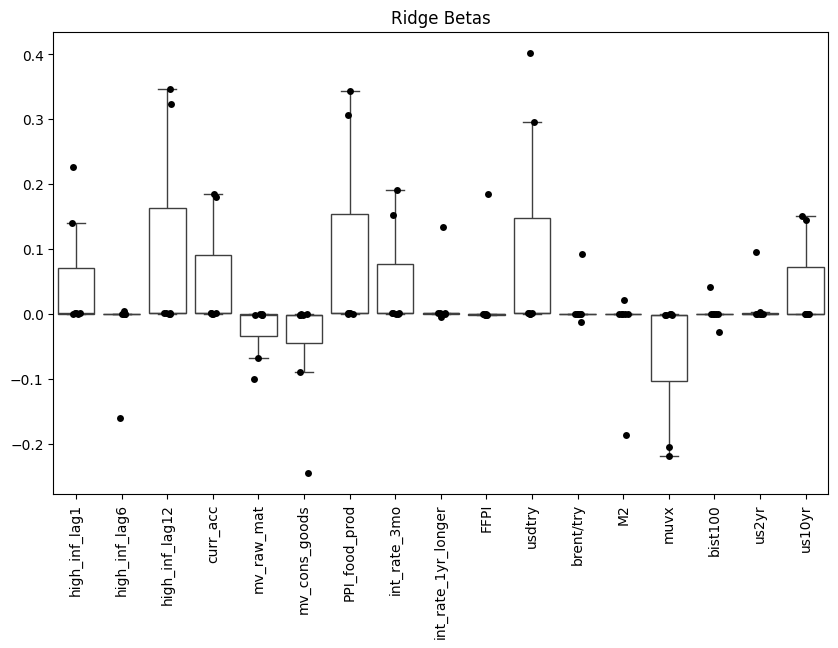

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=l2_betas, color="white", showfliers=False)
sns.stripplot(data=l2_betas, color="black")
plt.title("Ridge Betas")
plt.xticks(rotation=90)
plt.show()

### Logistic Regression + ElasticNet

In [ ]:
params = {"model__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          "model__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]}
pipe = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(solver="saga", penalty="elasticnet", max_iter=400))])

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(pipe, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X,y)
  mdl = grid_search.best_estimator_[1]
  pipe = Pipeline([("scaler", StandardScaler()), ("model", mdl)])
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train,y_train)
    yhat = pipe.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  elnet_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  elnet_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  elnet_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  elnet_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  elnet_betas.loc[name] = pipe.named_steps["model"].coef_[0]

elnet_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 35 candidates, totalling 5880 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 168 folds for each of 35 candidates, totalling 5880 fits
Fitting 168 folds for each of 35 candidates, totalling 5880 fits
Fitting 150 folds for each of 35 candidates, totalling 5250 fits
Fitting 144 folds for each of 35 candidates, totalling 5040 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 35 candidates, totalling 4830 fits
Fitting 210 folds for each of 35 candidates, totalling 7350 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9107,0.7500,0.1765,0.5849
1,TS CV w/ 6 period gap,0.9048,1.0000,0.0588,0.5294
2,TS CV w/ 12 period gap,0.9048,0.6667,0.1176,0.5555
3,Sliding window,0.9067,1.0000,0.1250,0.5625
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.8986,0.6000,0.2000,0.5919
6,hv-blocked,0.8905,0.6000,0.1250,0.5571


In [ ]:
elnet_betas.T

,TS CV,TS CV w/ 6 period gap,TS CV w/ 12 period gap,Sliding window,Sliding window w/ 6 period gap,Sliding window w/ 12 period gap,hv-blocked
high_inf_lag1,0.103449,0.053693,0.041622,0.206096,0.0,0.281381,0.041618
high_inf_lag6,0.012228,0.0,0.00184,-0.102522,0.0,-0.412169,0.001846
high_inf_lag12,0.489888,0.292341,0.289104,0.293231,0.0,0.426455,0.289112
curr_acc,0.174548,0.169591,0.133199,0.1485,0.0,0.125386,0.133199
mv_raw_mat,0.0,-0.063673,-0.085168,-0.049915,0.0,0.0,-0.085154
mv_cons_goods,-0.468551,-0.261776,-0.304381,-0.029994,0.0,-0.253226,-0.304392
PPI_food_prod,0.34507,0.138896,0.15121,0.337664,0.0,0.048954,0.151213
int_rate_3mo,0.380243,0.226374,0.206062,0.10885,0.0,0.243791,0.206055
int_rate_1yr_longer,0.043503,0.180773,0.207843,0.0,0.0,0.0,0.20786
FFPI,0.11378,-0.026287,-0.036699,0.127783,0.0,0.345502,-0.036707


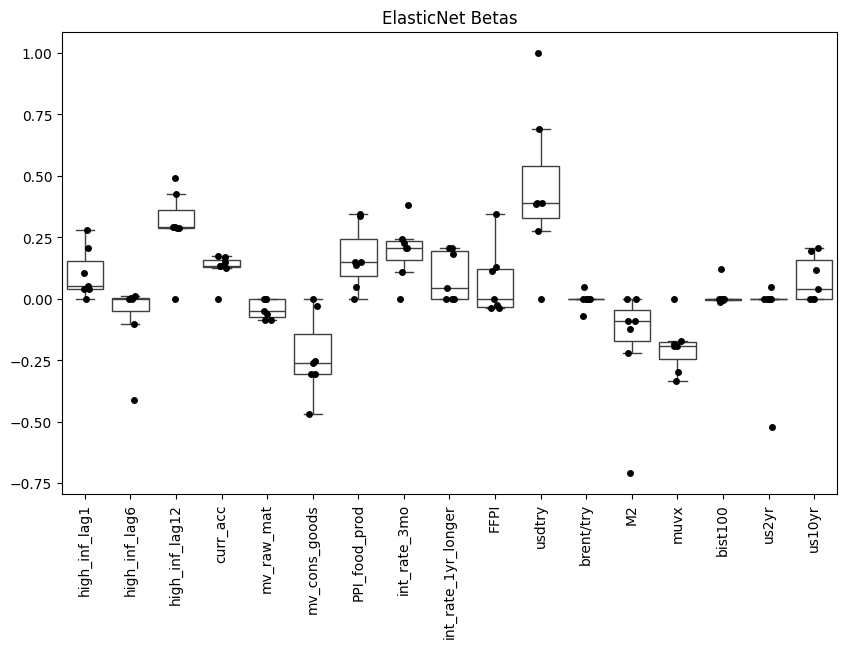

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=elnet_betas, color="white", showfliers=False)
sns.stripplot(data=elnet_betas, color="black")
plt.title("ElasticNet Betas")
plt.xticks(rotation=90)
plt.show()

### PCA as regularization

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
pve_cumsum = pca.explained_variance_ratio_.cumsum()
pve_cumsum

array([0.1638855 , 0.32545115, 0.4400857 , 0.51631892, 0.58702438,
       0.65159789, 0.70966668, 0.7609969 , 0.80806241, 0.85097457,
       0.89169936, 0.92695499, 0.95681101, 0.97568752, 0.98756999,
       0.99813761, 1.        ])

In [ ]:
X_pca_reduced = PCA(n_components=10).fit_transform(X_scaled) # i aim for 85% variance explained
X_pca_reduced = pd.DataFrame(X_pca_reduced, index=X.index)

In [ ]:
logreg_pca_results = pd.DataFrame(index=cv_dict.keys())
l1_pca_results = pd.DataFrame(index=cv_dict.keys())
l2_pca_results = pd.DataFrame(index=cv_dict.keys())
elnet_pca_results = pd.DataFrame(index=cv_dict.keys())

#### Logistic Reg + PCA

In [ ]:
logreg_mdl = LogisticRegression(penalty=None, max_iter=500)
for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  for train_index, test_index in cv:
    X_train, X_test = X_pca_reduced.iloc[train_index], X_pca_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logreg_mdl.fit(X_train,y_train)
    yhat = logreg_mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  logreg_pca_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  logreg_pca_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  logreg_pca_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  logreg_pca_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

logreg_pca_results.round(4).reset_index(names="cv method")

,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8869,0.3750,0.1765,0.5717
1,TS CV w/ 6 period gap,0.8810,0.3636,0.2353,0.5945
2,TS CV w/ 12 period gap,0.8690,0.3077,0.2353,0.5878
3,Sliding window,0.8667,0.3889,0.4375,0.6777
4,Sliding window w/ 6 period gap,0.8333,0.3182,0.4375,0.6602
5,Sliding window w/ 12 period gap,0.8406,0.2667,0.2667,0.5886
6,hv-blocked,0.8714,0.3333,0.1250,0.5464


#### L1 + PCA

In [ ]:
params = {"C": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
l1_mdl = LogisticRegression(solver="liblinear", penalty="l1")

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(l1_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X_pca_reduced, y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X_pca_reduced.iloc[train_index], X_pca_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  l1_pca_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  l1_pca_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  l1_pca_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  l1_pca_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

l1_pca_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 8 candidates, totalling 1344 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 168 folds for each of 8 candidates, totalling 1344 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 150 folds for each of 8 candidates, totalling 1200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 144 folds for each of 8 candidates, totalling 1152 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 8 candidates, totalling 1104 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 210 folds for each of 8 candidates, totalling 1680 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8988,0.0000,0.0000,0.500
1,TS CV w/ 6 period gap,0.8988,0.0000,0.0000,0.500
2,TS CV w/ 12 period gap,0.9107,0.6667,0.2353,0.611
3,Sliding window,0.8933,0.0000,0.0000,0.500
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.500
5,Sliding window w/ 12 period gap,0.8913,0.0000,0.0000,0.500
6,hv-blocked,0.8857,0.0000,0.0000,0.500


#### L2 + PCA

In [ ]:
params = {"C": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
l2_mdl = LogisticRegression()

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(l2_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X_pca_reduced, y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X_pca_reduced.iloc[train_index], X_pca_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  l2_pca_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  l2_pca_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  l2_pca_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  l2_pca_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

l2_pca_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 168 folds for each of 8 candidates, totalling 1344 fits
Fitting 150 folds for each of 8 candidates, totalling 1200 fits
Fitting 144 folds for each of 8 candidates, totalling 1152 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 8 candidates, totalling 1104 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 210 folds for each of 8 candidates, totalling 1680 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9048,0.6667,0.1176,0.5555
1,TS CV w/ 6 period gap,0.9107,1.0000,0.1176,0.5588
2,TS CV w/ 12 period gap,0.9107,1.0000,0.1176,0.5588
3,Sliding window,0.9067,1.0000,0.1250,0.5625
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.8913,0.0000,0.0000,0.5000
6,hv-blocked,0.8905,0.6000,0.1250,0.5571


#### ElasticNet + PCA

In [ ]:
params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]}
elnet_mdl = LogisticRegression(solver="saga", penalty="elasticnet", max_iter=500)

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(elnet_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X_pca_reduced, y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X_pca_reduced.iloc[train_index], X_pca_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  elnet_pca_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  elnet_pca_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  elnet_pca_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  elnet_pca_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

elnet_pca_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 35 candidates, totalling 5880 fits
Fitting 168 folds for each of 35 candidates, totalling 5880 fits
Fitting 168 folds for each of 35 candidates, totalling 5880 fits
Fitting 150 folds for each of 35 candidates, totalling 5250 fits
Fitting 144 folds for each of 35 candidates, totalling 5040 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 35 candidates, totalling 4830 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 210 folds for each of 35 candidates, totalling 7350 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9048,0.6667,0.1176,0.5555
1,TS CV w/ 6 period gap,0.9048,1.0000,0.0588,0.5294
2,TS CV w/ 12 period gap,0.9107,0.6667,0.2353,0.6110
3,Sliding window,0.9000,1.0000,0.0625,0.5312
4,Sliding window w/ 6 period gap,0.8889,0.0000,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.9058,0.6667,0.2667,0.6252
6,hv-blocked,0.8952,0.7500,0.1250,0.5598


## Decision Tree

In [ ]:
tree_importances = pd.DataFrame(columns=X.columns, index=cv_dict.keys())
forest_importances = pd.DataFrame(columns=X.columns, index=cv_dict.keys())

tree_results = pd.DataFrame(index=cv_dict.keys())
forest_results = pd.DataFrame(index=cv_dict.keys())

In [ ]:
params = {"max_depth": [3, 5, 7, 9, None]}
tree_mdl = DecisionTreeClassifier(random_state=0)

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(tree_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X,y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  tree_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  tree_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  tree_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  tree_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  tree_importances.loc[name] = grid_search.best_estimator_.feature_importances_

tree_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 150 folds for each of 5 candidates, totalling 750 fits
Fitting 144 folds for each of 5 candidates, totalling 720 fits
Fitting 138 folds for each of 5 candidates, totalling 690 fits
Fitting 210 folds for each of 5 candidates, totalling 1050 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8810,0.3333,0.1765,0.5684
1,TS CV w/ 6 period gap,0.8869,0.4000,0.2353,0.5978
2,TS CV w/ 12 period gap,0.8750,0.3333,0.2353,0.5912
3,Sliding window,0.8467,0.3333,0.4375,0.6665
4,Sliding window w/ 6 period gap,0.8194,0.2500,0.3125,0.5977
5,Sliding window w/ 12 period gap,0.8696,0.3846,0.3333,0.6341
6,hv-blocked,0.8476,0.1000,0.0417,0.4966


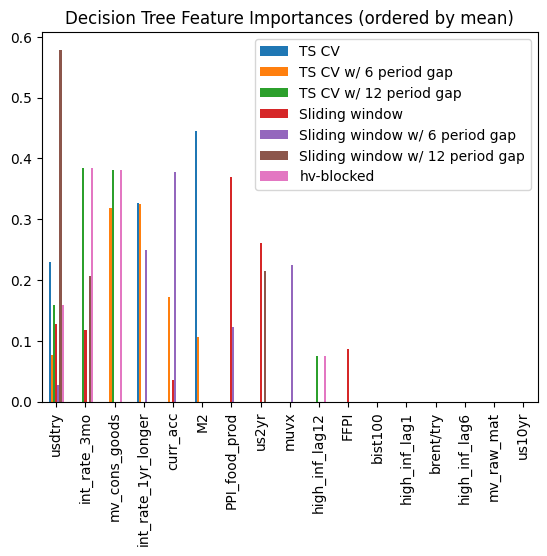

In [ ]:
idx_dt = tree_importances.mean(axis=0).sort_values(ascending=False).index
tree_importances[idx_dt].T.plot(kind='bar')
plt.title("Decision Tree Feature Importances (ordered by mean)")
plt.show()

### Decision Tree + PCA

In [ ]:
tree_pca_results = pd.DataFrame(index=cv_dict.keys())

In [ ]:
params = {"max_depth": [3, 5, 7, 9, None]}
tree_mdl = DecisionTreeClassifier(random_state=0)

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(tree_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X_pca_reduced, y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X_pca_reduced.iloc[train_index], X_pca_reduced.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  tree_pca_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  tree_pca_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  tree_pca_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  tree_pca_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

tree_pca_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 150 folds for each of 5 candidates, totalling 750 fits
Fitting 144 folds for each of 5 candidates, totalling 720 fits
Fitting 138 folds for each of 5 candidates, totalling 690 fits
Fitting 210 folds for each of 5 candidates, totalling 1050 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8869,0.3333,0.1176,0.5456
1,TS CV w/ 6 period gap,0.8869,0.2500,0.0588,0.5195
2,TS CV w/ 12 period gap,0.8988,0.5000,0.0588,0.5261
3,Sliding window,0.8600,0.3077,0.2500,0.5914
4,Sliding window w/ 6 period gap,0.8750,0.4167,0.3125,0.6289
5,Sliding window w/ 12 period gap,0.8551,0.2222,0.1333,0.5382
6,hv-blocked,0.8571,0.2500,0.1250,0.5383


## Random Forest

In [ ]:
params = {"max_depth": [3, 5, 7, 9, None]}
forest_mdl = RandomForestClassifier(random_state=0, n_estimators=50)

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(forest_mdl, params, cv=cv, n_jobs=-1, verbose=True, refit=True)
  grid_search.fit(X,y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  forest_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  forest_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  forest_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  forest_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)
  forest_importances.loc[name] = grid_search.best_estimator_.feature_importances_

forest_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 168 folds for each of 5 candidates, totalling 840 fits
Fitting 150 folds for each of 5 candidates, totalling 750 fits
Fitting 144 folds for each of 5 candidates, totalling 720 fits
Fitting 138 folds for each of 5 candidates, totalling 690 fits
Fitting 210 folds for each of 5 candidates, totalling 1050 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.9107,1.0000,0.1176,0.5588
1,TS CV w/ 6 period gap,0.8988,0.5000,0.1176,0.5522
2,TS CV w/ 12 period gap,0.8988,0.5000,0.1176,0.5522
3,Sliding window,0.9067,0.6667,0.2500,0.6175
4,Sliding window w/ 6 period gap,0.8819,0.4000,0.1250,0.5508
5,Sliding window w/ 12 period gap,0.8841,0.0000,0.0000,0.4959
6,hv-blocked,0.8857,0.5000,0.0417,0.5181


<Figure size 1000x600 with 0 Axes>

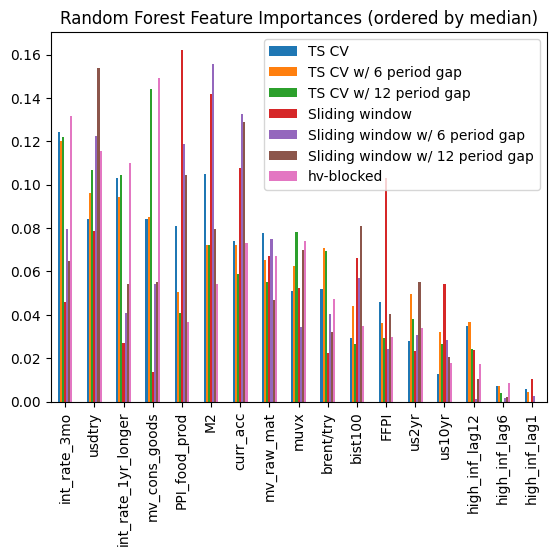

In [ ]:
plt.figure(figsize=(10, 6))
idx_rf = forest_importances.median(axis=0).sort_values(ascending=False).index
forest_importances[idx_rf].T.plot(kind="bar")
plt.title("Random Forest Feature Importances (ordered by median)")
plt.show()

## Support Vector Machines

In [ ]:
svm_results = pd.DataFrame(index=cv_dict.keys())

In [ ]:
params = {"C": [0.001, 0.01, 0.1, 1, 10],
          #"kernel": ["linear", "rbf"],
          "class_weight": ["balanced", None]
          }
svm_mdl = SVC()

for name, cv in cv_dict.items():
  y_actual = []
  y_pred = []
  grid_search = GridSearchCV(svm_mdl, params, cv=cv, verbose=True, refit=True)
  grid_search.fit(X, y)
  mdl = grid_search.best_estimator_
  for train_index, test_index in cv:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    mdl.fit(X_train,y_train)
    yhat = mdl.predict(X_test)
    y_actual.extend(y_test)
    y_pred.extend(yhat)

  svm_results.loc[name, "accuracy"] = accuracy_score(y_actual, y_pred)
  svm_results.loc[name, "precision"] = precision_score(y_actual, y_pred)
  svm_results.loc[name, "recall"] = recall_score(y_actual, y_pred)
  svm_results.loc[name, "roc auc"] = roc_auc_score(y_actual, y_pred)

svm_results.round(4).reset_index(names="cv method")

Fitting 168 folds for each of 10 candidates, totalling 1680 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 168 folds for each of 10 candidates, totalling 1680 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 168 folds for each of 10 candidates, totalling 1680 fits
Fitting 150 folds for each of 10 candidates, totalling 1500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 144 folds for each of 10 candidates, totalling 1440 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 138 folds for each of 10 candidates, totalling 1380 fits
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


,cv method,accuracy,precision,recall,roc auc
0,TS CV,0.8988,0.0,0.0000,0.5000
1,TS CV w/ 6 period gap,0.8988,0.0,0.0000,0.5000
2,TS CV w/ 12 period gap,0.9048,1.0,0.0588,0.5294
3,Sliding window,0.8933,0.0,0.0000,0.5000
4,Sliding window w/ 6 period gap,0.8889,0.0,0.0000,0.5000
5,Sliding window w/ 12 period gap,0.8986,1.0,0.0667,0.5333
6,hv-blocked,0.8952,1.0,0.0833,0.5417


## Results

In [ ]:
logreg_results["model"] = "log. reg."
logreg_pca_results["model"] = "log. reg + PCA"
l1_results["model"] = "L1"
l1_pca_results["model"] = "L1 + PCA"
l2_results["model"] = "L2"
l2_pca_results["model"] = "L2 + PCA"
elnet_results["model"] = "ElNet"
elnet_pca_results["model"] = "ElNet + PCA"
tree_results["model"] = "DT"
forest_results["model"] = "RF"
svm_results["model"] = "SVM"

In [ ]:
results_table = pd.concat([logreg_results, logreg_pca_results,
                           l1_results, l1_pca_results,
                           l2_results, l2_pca_results,
                           elnet_results, elnet_pca_results,
                           tree_results, forest_results,
                           svm_results]).round(4).reset_index(names="cv method")

In [ ]:
# eliminating intercept only models
intercept_only_models = results_table[(results_table["precision"] == 0) & (results_table["recall"] == 0) & (results_table["roc auc"] == 0.5)]
results_table = results_table.drop(intercept_only_models.index)

In [ ]:
results_table.sort_values(["accuracy", "roc auc"], ascending=False).head(20)

,cv method,accuracy,precision,recall,roc auc,model
23,TS CV w/ 12 period gap,0.9107,0.6667,0.2353,0.6110,L1 + PCA
51,TS CV w/ 12 period gap,0.9107,0.6667,0.2353,0.6110,ElNet + PCA
42,TS CV,0.9107,0.7500,0.1765,0.5849,ElNet
36,TS CV w/ 6 period gap,0.9107,1.0000,0.1176,0.5588,L2 + PCA
37,TS CV w/ 12 period gap,0.9107,1.0000,0.1176,0.5588,L2 + PCA
63,TS CV,0.9107,1.0000,0.1176,0.5588,RF
66,Sliding window,0.9067,0.6667,0.2500,0.6175,RF
31,Sliding window,0.9067,1.0000,0.1250,0.5625,L2
38,Sliding window,0.9067,1.0000,0.1250,0.5625,L2 + PCA
45,Sliding window,0.9067,1.0000,0.1250,0.5625,ElNet


In [ ]:
def my_subplot(group, metric, axx):
  sns.boxplot(data=results_table, y=group, x=metric,
              order=results_table.groupby(group)[metric].mean().sort_values(ascending=False).index,
              color="white", showfliers=False, ax=axx)
  sns.swarmplot(data=results_table, y=group, x=metric,
                order=results_table.groupby(group)[metric].mean().sort_values(ascending=False).index,
                color="black", ax=axx)
  axx.set_title(f"{metric.title()}")
  axx.set_xlabel("")
  axx.set_ylabel("")
  axx.grid(axis="x", linestyle="-.")

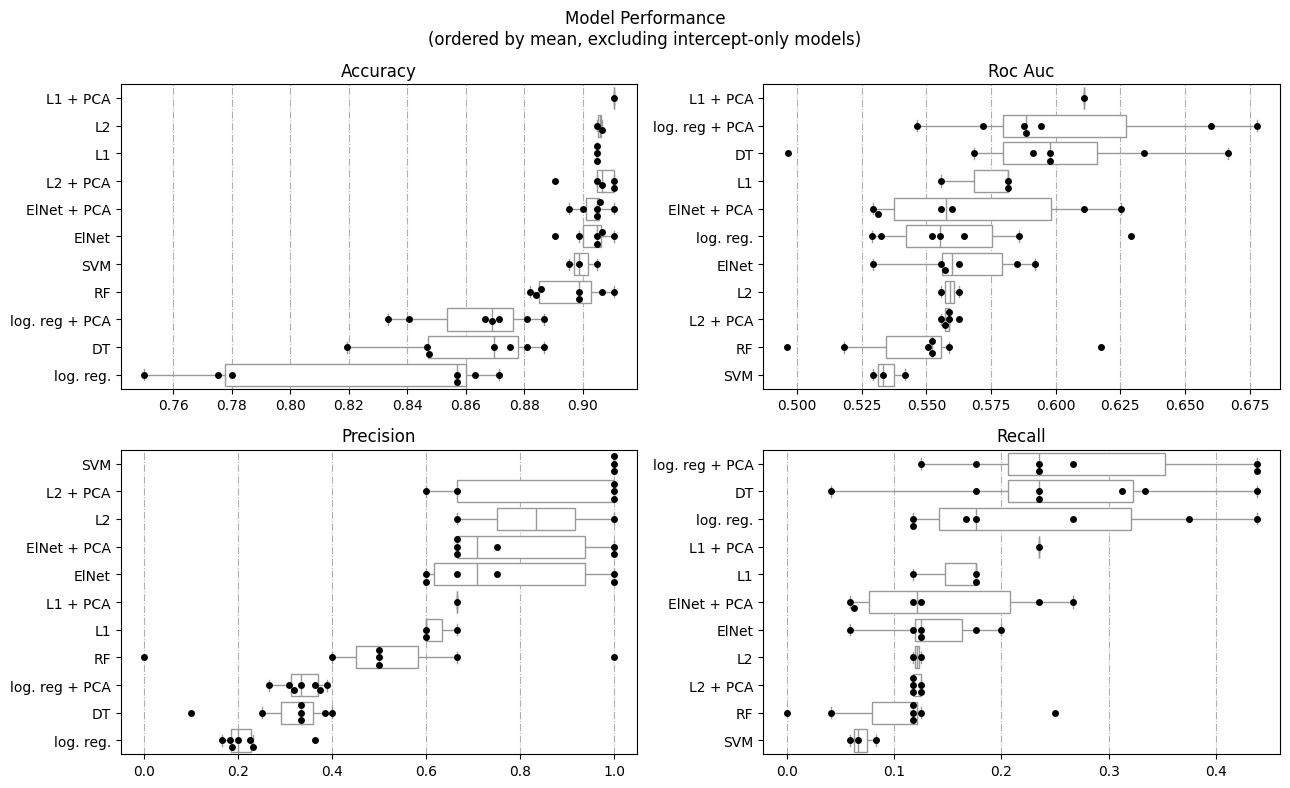

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
my_subplot("model", "accuracy", axes[0, 0])
my_subplot("model", "roc auc", axes[0, 1])
my_subplot("model", "precision", axes[1, 0])
my_subplot("model", "recall", axes[1, 1])
fig.suptitle("Model Performance\n(ordered by mean, excluding intercept-only models)")
plt.tight_layout()

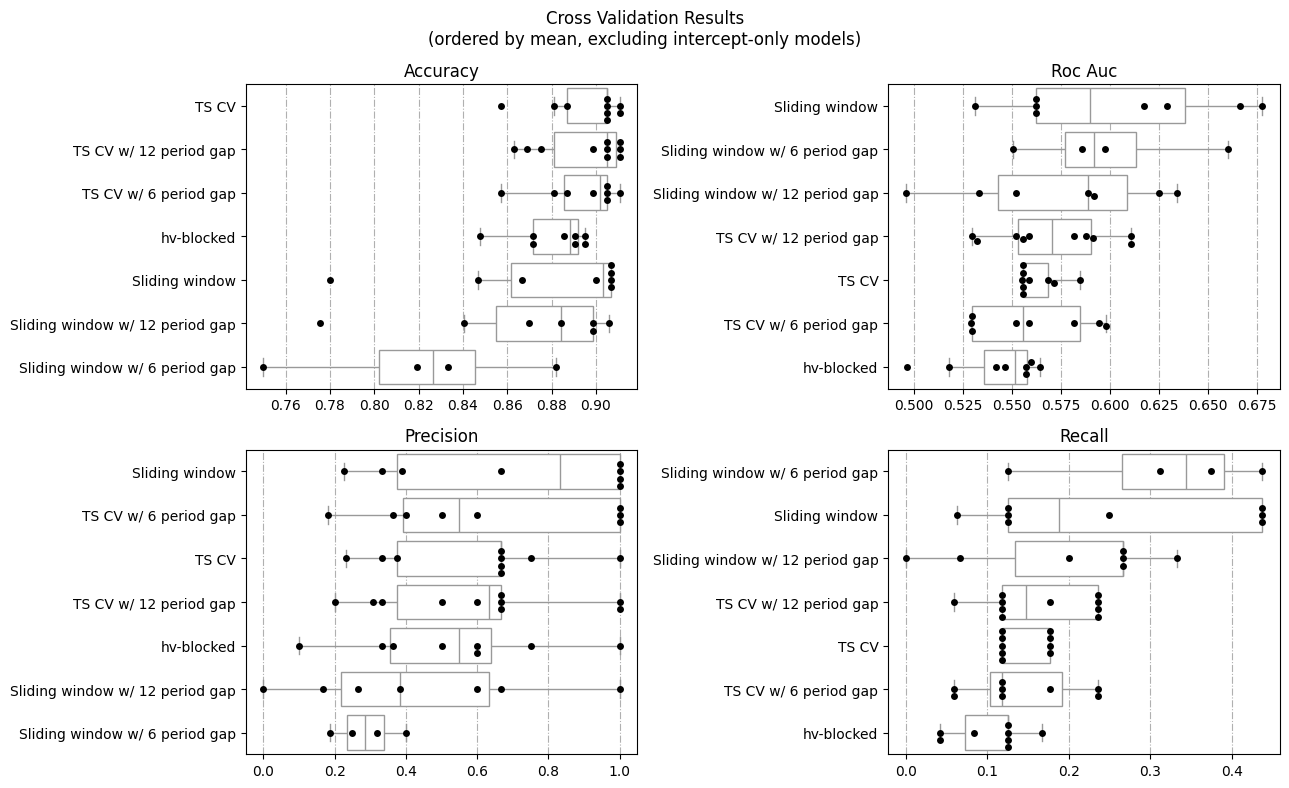

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
my_subplot("cv method", "accuracy", axes[0, 0])
my_subplot("cv method", "roc auc", axes[0, 1])
my_subplot("cv method", "precision", axes[1, 0])
my_subplot("cv method", "recall", axes[1, 1])
fig.suptitle("Cross Validation Results\n(ordered by mean, excluding intercept-only models)")
plt.tight_layout()

## Examples on Cross Validation Techniques

This part is a demonstration of how the alternative CV techniques work.

In [ ]:
sample = np.array([0,1,2,3,4,5,6,7,8,9,10])

In [ ]:
# sliding window
for train, test in my_cv(sample, window=5):
  print("TRAIN:", train)
  print("TEST:", test)

TRAIN: [0 1 2 3 4]
TEST: [5]
TRAIN: [1 2 3 4 5]
TEST: [6]
TRAIN: [2 3 4 5 6]
TEST: [7]
TRAIN: [3 4 5 6 7]
TEST: [8]
TRAIN: [4 5 6 7 8]
TEST: [9]
TRAIN: [5 6 7 8 9]
TEST: [10]


In [ ]:
# sliding window with a gap
for train, test in my_cv(sample,5,1):
  print("TRAIN:", train)
  print("TEST:", test)

TRAIN: [0 1 2 3 4]
TEST: [6]
TRAIN: [1 2 3 4 5]
TEST: [7]
TRAIN: [2 3 4 5 6]
TEST: [8]
TRAIN: [3 4 5 6 7]
TEST: [9]
TRAIN: [4 5 6 7 8]
TEST: [10]


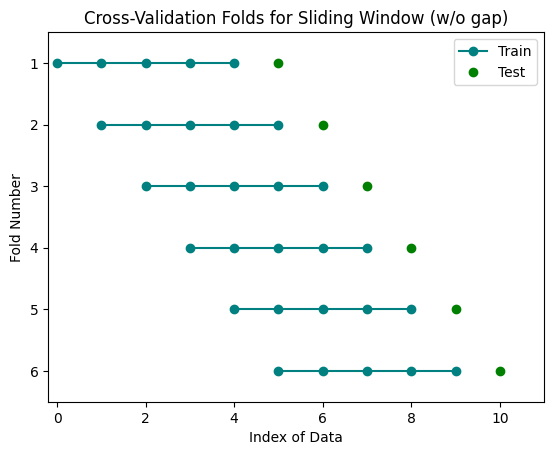

In [ ]:
fold = 1
for train_indices, test_indices in my_cv(sample,5):
    plt.plot(train_indices, np.ones(len(train_indices)) * fold, 'o-', color='teal')
    plt.plot(test_indices, np.ones(len(test_indices)) * fold , 'o', color='green')
    fold += 1
plt.xlabel("Index of Data")
plt.ylabel("Fold Number")
plt.xlim(-0.2, len(sample))
plt.ylim(fold -.5, 0.5)
plt.title(f"Cross-Validation Folds for Sliding Window (w/o gap)")
plt.legend(["Train", "Test"])
plt.show()

In [ ]:
# hv-blocked cv
for train, test in my_hvb(sample, 2):
  print("TRAIN:", train)
  print("TEST:", test)

TRAIN: [ 3  4  5  6  7  8  9 10]
TEST: [0]
TRAIN: [ 4  5  6  7  8  9 10]
TEST: [1]
TRAIN: [ 5  6  7  8  9 10]
TEST: [2]
TRAIN: [ 0  6  7  8  9 10]
TEST: [3]
TRAIN: [ 0  1  7  8  9 10]
TEST: [4]
TRAIN: [ 0  1  2  8  9 10]
TEST: [5]
TRAIN: [ 0  1  2  3  9 10]
TEST: [6]
TRAIN: [ 0  1  2  3  4 10]
TEST: [7]
TRAIN: [0 1 2 3 4 5]
TEST: [8]
TRAIN: [0 1 2 3 4 5 6]
TEST: [9]
TRAIN: [0 1 2 3 4 5 6 7]
TEST: [10]


In [ ]:
# hv-blocked cv with embargo
for train, test in my_hvb(sample, 2, 1):
  print("TRAIN:", train)
  print("TEST:", test)

TRAIN: [ 4  5  6  7  8  9 10]
TEST: [0]
TRAIN: [ 5  6  7  8  9 10]
TEST: [1]
TRAIN: [ 6  7  8  9 10]
TEST: [2]
TRAIN: [ 0  7  8  9 10]
TEST: [3]
TRAIN: [ 0  1  8  9 10]
TEST: [4]
TRAIN: [ 0  1  2  9 10]
TEST: [5]
TRAIN: [ 0  1  2  3 10]
TEST: [6]
TRAIN: [0 1 2 3 4]
TEST: [7]
TRAIN: [0 1 2 3 4 5]
TEST: [8]
TRAIN: [0 1 2 3 4 5 6]
TEST: [9]
TRAIN: [0 1 2 3 4 5 6 7]
TEST: [10]


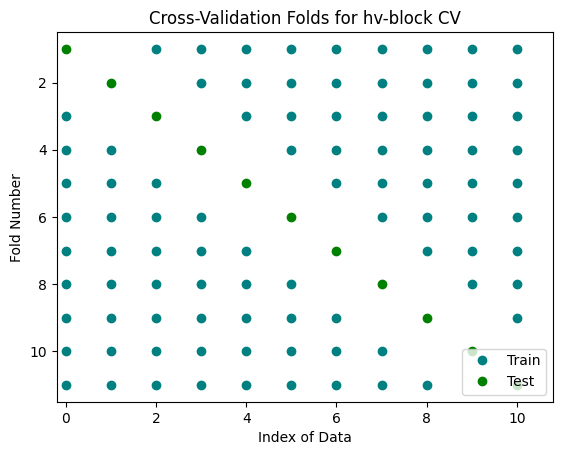

In [ ]:
fold = 1
for train_indices, test_indices in my_hvb(sample, 1):
    plt.plot(train_indices, np.ones(len(train_indices)) * fold, "o", color="teal")
    plt.plot(test_indices, np.ones(len(test_indices)) * fold , "o", color="green")
    fold += 1
plt.xlabel("Index of Data")
plt.ylabel("Fold Number")
plt.xlim(-0.2, len(sample)-0.2)
plt.ylim(fold -.5, 0.5)
plt.title(f"Cross-Validation Folds for hv-block CV")
plt.legend(["Train", "Test"], loc="lower right")
plt.show()